<a href="https://colab.research.google.com/github/matchaginseng/fuzzy-palm-tree/blob/main/logit_lens_on_vit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## logit lens on vit

In [23]:
# if this says "Tesla T4" or "Tesla P100" then you'll be able to run this notebook
#
# otherwise, try again with menu Runtime --> Factory reset runtime
# or try at another time of day
#
# note: other GPUs may be able to run smaller gpt2s -- try replacing "1558M" as model_name with eg "774M"

!nvidia-smi

Mon Dec 11 04:15:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

setup: install, clone repo, etc.

In [24]:
!pip install transformers

set up vit: https://huggingface.co/google/vit-base-patch32-384, run prediction on cat

In [25]:
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests
import numpy as np
from torch import nn

In [59]:
# grab image
# url = 'https://farm8.staticflickr.com/7390/8860478142_d1743aa5bc_z.jpg'
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = 'http://farm9.staticflickr.com/8094/8404835886_68a69089da_z.jpg' # sheep
# url = 'http://farm4.staticflickr.com/3244/2815056162_8a1612ff20_z.jpg' # plate of food
# url = 'http://farm3.staticflickr.com/2343/3544344028_c2cd3d736f_z.jpg' # girl with sheep
# url = 'http://farm4.staticflickr.com/3101/3237159405_2530304691_z.jpg' # messy desk
url = 'http://farm1.staticflickr.com/43/87305087_a9d38069db_z.jpg' # cats eating out of bowl
image = Image.open(requests.get(url, stream=True).raw)

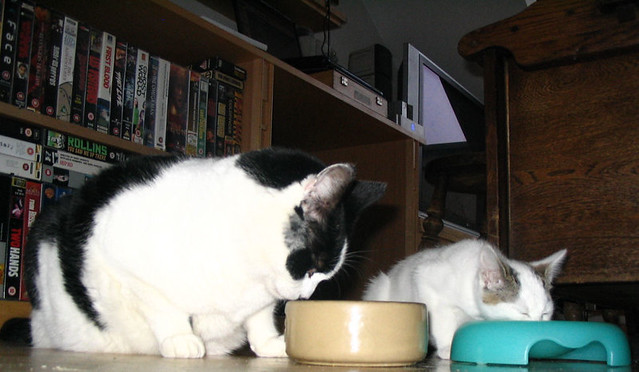

In [60]:
image

In [61]:
# overall run
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch32-384')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch32-384', output_hidden_states=True)

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Predicted class: cup


In [62]:
hidden_states = outputs.hidden_states

In [63]:
pretrained_dict = model.state_dict()

In [64]:
norm_weights = pretrained_dict["vit.layernorm.weight"]
norm_bias = pretrained_dict["vit.layernorm.bias"]

classifier_weights = pretrained_dict["classifier.weight"]
classifier_bias = pretrained_dict["classifier.bias"]

layernorm = nn.LayerNorm((768,), eps=1e-12, elementwise_affine=True)
layernorm.weight = torch.nn.Parameter(norm_weights)
layernorm.bias = torch.nn.Parameter(norm_bias)

classifier = nn.Linear(in_features=768, out_features=1000, bias=True)
classifier.weight = torch.nn.Parameter(classifier_weights)
classifier.bias = torch.nn.Parameter(classifier_bias)

In [65]:
classified_intermediaries = []

for i in range(len(hidden_states)):
  # pass the hidden states of layer i through norm and classifier
  normed_state = layernorm(hidden_states[i])
  classified_state = classifier(normed_state)
  # classified_state = np.matmul(normed_state.detach().numpy(), classifier_weights.T) + classifier_bias

  classified_intermediaries.append(classified_state)

In [66]:
classified_intermediaries[0][0].shape

torch.Size([145, 1000])

In [67]:
for val in classified_intermediaries:
  predicted_class_idx = val[0][0].argmax(-1).item()
  print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: hyena, hyaena
Predicted class: plunger, plumber's helper
Predicted class: ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin
Predicted class: pole
Predicted class: cowboy hat, ten-gallon hat
Predicted class: cowboy hat, ten-gallon hat
Predicted class: fur coat
Predicted class: wig
Predicted class: fur coat
Predicted class: paper towel
Predicted class: Egyptian cat
Predicted class: tiger cat
Predicted class: cup


In [ ]:
# https://stackoverflow.com/questions/70986805/how-to-save-and-load-only-particular-layers-of-a-neural-network-with-pytorch